In [1]:
#classic
import pandas as pd
import numpy as np
import string
import os

#graphs and tables
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from Visualization import poincare_2d_visualization
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

from tabulate import tabulate


#gensim
from gensim.models.poincare import PoincareModel, PoincareKeyedVectors
from gensim.test.utils import datapath
from gensim.utils import check_output
from collections import Counter, defaultdict
import itertools
import logging
from gensim import utils, matutils
import csv

#python files
import Evaluation
import Visualization
import LinkPrediction
import KMeans_Poincare

#interaction
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
#Loading Facebook categories

def load_fb_data(data):
    dictn = {"Tag EN - 2" : "Tag EN - 1",
                "Tag EN - 3" : "Tag EN - 2"}
    
    fb_cat = pd.read_excel(data, header=1)
    fb_cat = fb_cat[["Tag EN "]][:1568]
    
    #split into 3 columns
    fb_cat[['Tag EN - 1', 'Tag EN - 2', "Tag EN - 3"]] = fb_cat['Tag EN '].str.split('|', 2, expand=True)
    fb_cat = fb_cat.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    master_ = fb_cat["Tag EN - 1"].drop_duplicates().values
    master = pd.DataFrame(list(zip(master_, master_)), columns = ["Tag EN - 1", "Tag EN - 2"])
    fb_cat.dropna(subset=['Tag EN - 2'], how='all', inplace=True)
    fb_cat.drop("Tag EN ", axis=1, inplace=True)
    
    data_3d = fb_cat[fb_cat["Tag EN - 3"].isna() == False]
    data_new = data_3d[["Tag EN - 1","Tag EN - 3"]]
    data_new.rename(columns=dictn, inplace=True)
    d_23 = data_3d[["Tag EN - 2","Tag EN - 3"]] #data with only 2 columns with no nan's
    d_23.rename(columns=dictn, inplace=True) #rename the columns to be 1,2
    fb_cat.drop("Tag EN - 3", axis=1, inplace=True) #drop column 3
    
    #Create the final table
    new_data = fb_cat.append(d_23)
    new_data = new_data.append(master)
    new_data = new_data.append(data_new)
    new_data = new_data[["Tag EN - 2", "Tag EN - 1"]]
    new_data = new_data.dropna(how="all", axis=0)
    new_data = new_data.drop_duplicates()
    
    tuples = [tuple(x) for x in new_data.values]

    return tuples
# -----------------------------------------------------------------------------------------------------//
def users_profile_data(data_path, i):
    
    try:
        categories = []
        prof_data = pd.read_csv(data_path, encoding='latin1') 
        insights_data = prof_data[(prof_data["type"] == "INSIGHT") & ((prof_data["value"] == "TRUE") | (prof_data["value"] == 1))]
        print("The user has %d interests." %len(insights_data))

        string = "Has interest in"
        categories = []
        for interest in insights_data["profileID"]:
            if string in interest:
                new = interest.replace(string, "")
                categories.append(new)
            else:
                print("We were not able to find any category")
    
    except:
        
        df = pd.read_csv(data_path, index_col="Unnamed: 0")
        user_cat = df.iloc[[i]][df.iloc[[i]]==1]
        categories = list(user_cat.dropna(axis = "columns", how="all"))
        
    
    data = pd.DataFrame(categories, columns = ["Tag EN"])
    data[['Tag EN - 1', 'Tag EN - 2', "Tag EN - 3"]] = data['Tag EN'].str.split('|', 2, expand=True)
    data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    data.dropna(subset=['Tag EN - 2'], how='all', inplace=True)
    data.drop(["Tag EN"], inplace=True, axis=1)
    all_cats = pd.concat([data['Tag EN - 1'], data['Tag EN - 2'], data['Tag EN - 3']])
    all_cats = all_cats.drop_duplicates()
    all_cats = all_cats.dropna(axis=0, how="all")
    return all_cats
# --------------------------------------------------------------------------------------------------------//
def users_non_profile_data(data_path):
    
    try:
        categories = []
        prof_data = pd.read_csv(data_path, encoding='latin1') 
        non_insights_data = prof_data[(prof_data["type"] == "INSIGHT") & (prof_data["value"] == "FALSE")]
        print("The user has %d explicit negative interests." %len(non_insights_data))

        string = "Has interest in"
        categories = []
        for interest in non_insights_data["profileID"]:
            if string in interest:
                new = interest.replace(string, "")
                categories.append(new)
            else:
                print("We were not able to find any category")
    
    except:
        df = pd.read_csv(data_path, index_col="Unnamed: 0")
        user_cat = df.iloc[[i]][df.iloc[[i]]==-1]
        categories = list(user_cat.dropna(axis = "columns", how="all"))

    data = pd.DataFrame(categories, columns = ["Tag EN"])
    try:
        data[['Tag EN - 1', 'Tag EN - 2', "Tag EN - 3"]] = data['Tag EN'].str.split('|', 2, expand=True)
        data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        data.dropna(subset=['Tag EN - 2'], how='all', inplace=True)
        data.drop(["Tag EN"], inplace=True, axis=1)
        all_cats = pd.concat([data['Tag EN - 1'], data['Tag EN - 2'], data['Tag EN - 3']])
        all_cats = all_cats.drop_duplicates()
        all_cats = all_cats.dropna(axis=0, how="all")
    except:
        data[['Tag EN - 1', 'Tag EN - 2']] = data['Tag EN'].str.split('|', 1, expand=True)
        data = data.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        data.dropna(subset=['Tag EN - 2'], how='all', inplace=True)
        data.drop(["Tag EN"], inplace=True, axis=1)
        all_cats = pd.concat([data['Tag EN - 1'], data['Tag EN - 2']])
        all_cats = all_cats.drop_duplicates()
        all_cats = all_cats.dropna(axis=0, how="all")
    return all_cats

In [3]:
tuples = load_fb_data("Data/Complete_Dataset_reference.xlsx")
tuples.sort()

C:\Users\titam\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [4]:
def load_poincare_gensim(input_filename):
    """Load embedding trained via Gensim PoincareModel.

    Parameters
    ----------
    filepath : str
        Path to model file.

    Returns:
        PoincareKeyedVectors instance.

    """
    model = PoincareModel.load(input_filename)
    return model.kv

model = load_poincare_gensim("output/output_file_200D_20N_0B_0R_200Ep.tsv")

In [5]:
#making the category together with the vector
dict_cat_coord = dict(zip(model.index_to_key, model.vectors))

#Get the best model coordinates
#Save the coordinates
coord = pd.DataFrame(model.vectors)
coord.to_csv("coordinates.csv", index=False)

In [28]:
from KMeans_Poincare import PoincareKMeans

points = np.loadtxt("coordinates.csv", delimiter=',', skiprows=1)

model_kmeans = PoincareKMeans(n_clusters=25,n_init=100,max_iter=200,tol=1e-10,verbose=True)
model_kmeans.fit_predict(points)

clust_labels = model_kmeans.labels_
centroids = model_kmeans.cluster_centers_



#clust_labels = np.loadtxt("clust_labels.csv", delimiter=",")
#centroids = np.loadtxt("centroids.csv", delimiter=",")

Iteration: 0 - Best Inertia: 72620.62823326146
Iteration: 1 - Best Inertia: 72620.62823326146
Iteration: 2 - Best Inertia: 71839.08490599718
Iteration: 3 - Best Inertia: 71839.08490599718
Iteration: 4 - Best Inertia: 71839.08490599718
Iteration: 5 - Best Inertia: 71839.08490599718
Iteration: 6 - Best Inertia: 71839.08490599718
Iteration: 7 - Best Inertia: 71704.73145902163
Iteration: 8 - Best Inertia: 71704.73145902163
Iteration: 9 - Best Inertia: 71704.73145902163
Iteration: 10 - Best Inertia: 71704.73145902163
Iteration: 11 - Best Inertia: 71704.73145902163
Iteration: 12 - Best Inertia: 71704.73145902163
Iteration: 13 - Best Inertia: 71704.73145902163
Iteration: 14 - Best Inertia: 71704.73145902163
Iteration: 15 - Best Inertia: 71704.73145902163
Iteration: 16 - Best Inertia: 71704.73145902163
Iteration: 17 - Best Inertia: 71704.73145902163
Iteration: 18 - Best Inertia: 71704.73145902163
Iteration: 19 - Best Inertia: 71704.73145902163
Iteration: 20 - Best Inertia: 71704.73145902163
It

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [53]:
clust_labels_1 = pd.Series(clust_labels)
clust_labels_1.to_csv("clust_labels.csv", index=False)
cent = pd.DataFrame(centroids)
cent.to_csv("centroids.csv", index=False)

In [18]:
#Create dataset of possible users with interest in some categories

fb_cat = pd.read_excel("Data/Complete_Dataset_reference.xlsx", header=1)
fb_cat = fb_cat[["Tag EN "]][:1568]
fb_cat.dropna(how="all", axis="rows", inplace=True)


cats = []
#split into 3 columns
for x in fb_cat.values:
    for z in x:
        cats.append(z)
        
categories_list = list(dict.fromkeys(cats))
        
df = pd.DataFrame(np.random.choice(list(set([0,1])), p=[0.95,0.05], size=(10000, len(categories_list))), columns=list(categories_list))
df

#save the dataset
df.to_csv("Users_Cats.csv")

In [6]:
df = pd.read_csv("Users_Cats.csv", index_col="Unnamed: 0")
df

Interest  Interest | Literary arts  Interest | Performance art  \
0            0                         0                           0   
1            1                         0                           0   
2            0                         0                           0   
3            1                         0                           0   
4            0                         0                           0   
...        ...                       ...                         ...   
9995         0                         0                           0   
9996         0                         0                           0   
9997         0                         0                           0   
9998         0                         0                           0   
9999         0                         0                           0   

      Interest | Performing arts  Interest | Science  Interest | Sports  \
0                              0                   0                  0   
1                              0                   0                  0   
2                              0                   0                  0   
3                              0                   0                  0   
4                              0                   0                  0   
...                          ...                 ...                ...   
9995                           0                   0                  0   
9996                           0                   0                  0   
9997                           0                   0                  0   
9998                           0                   0                  0   
9999                           0                   0                  0   

      Interest | Visual arts  Community organisation  \
0                          0                       0   
1                          0                       0   
2                          0                       0   
3                          0                       0   
4                          0                       0   
...                      ...                     ...   
9995                       0                       0   
9996                       0                       0   
9997                       0                       0   
9998                       0                       0   
9999                       0                       0   

      Community organisation | Armed forces  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   
...                                     ...   
9995                                      0   
9996                                      0   
9997                                      1   
9998                                      0   
9999                                      0   

      Community organisation | Charity organisation  ...  \
0                                                 0  ...   
1                                                 0  ...   
2                                                 0  ...   
3                                                 1  ...   
4                                                 0  ...   
...                                             ...  ...   
9995                                              0  ...   
9996                                              0  ...   
9997                                              0  ...   
9998                                              0  ...   
9999                                              0  ...   

      Other | TypeAhead | Pet Tricks  Other | TypeAhead | Public figure type  \
0                                  0                                       0   
1                                  0                                       0   
2                                  0     

In [207]:
def new_pred(vect):
    n_samples,n_clusters = vect.shape[0],centroids.shape[0]

    distances = np.zeros((n_samples,n_clusters))
    
    cent = []
    for i in range(n_clusters):
        
        centroid = np.tile(centroids[i,:],(n_samples,1))
        den1 = 1-np.linalg.norm(vect)**2
        den2 = 1-np.linalg.norm(centroid, axis=1)**2
        the_num = np.linalg.norm(vect-centroid, axis=1)**2
        distances[:,i] = np.arccosh(1+2*the_num/(den1*den2))
        
        #print(distances[:,24])
        cent.append(centroid)
        
    return np.argmin(distances), cent

# -----------------------------------------------------------------------//
def weight_average(all_cats):
    clust = []
    for x in all_cats:
        vect = model.get_vector(x)
        new_clust = new_pred(vect)
        clust.append(new_clust)

    a = np.unique(clust, return_counts=True)
    weighted_avg = np.average(a[0], weights=a[1])
    return weighted_avg

In [113]:
users_group

[10.173076923076923, 10.125, 10.153153153153154, 10.75268817204301]

In [148]:
vect.shape

(1, 200)

In [286]:
vectors_users = []

for i in range(1,1501):
    
    print(f"user {i}")
    
    all_cats = users_profile_data("Users_Cats.csv", i)
    
    vectors = []
    
    for x in all_cats:
        vect = model.get_vector(x)
        vect = vect.reshape(1,200)
        vectors.append(vect)
          
    # concatenating all vector coordinates         
    v = np.concatenate(vectors)
    #print(v.shape)
    
    # average for each user 
    mean_vectors_ = np.mean(v, axis=0,keepdims=True)
    #mean_vectors = mean_vectors.reshape(1,-1)
    #print(mean_vectors_.shape)
    
    # append mean from all users
    vectors_users.append(mean_vectors_)


vector_users = np.array(vectors_users)
vector_users = vector_users.reshape(-1,200)
print(vector_users.shape)

# reduncing the 200D into 2D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=100, n_iter=5000)
z = tsne.fit_transform(vector_users)


user 1
user 2
user 3
user 4
user 5
user 6
user 7
user 8
user 9
user 10
user 11
user 12
user 13
user 14
user 15
user 16
user 17
user 18
user 19
user 20
user 21
user 22
user 23
user 24
user 25
user 26
user 27
user 28
user 29
user 30
user 31
user 32
user 33
user 34
user 35
user 36
user 37
user 38
user 39
user 40
user 41
user 42
user 43
user 44
user 45
user 46
user 47
user 48
user 49
user 50
user 51
user 52
user 53
user 54
user 55
user 56
user 57
user 58
user 59
user 60
user 61
user 62
user 63
user 64
user 65
user 66
user 67
user 68
user 69
user 70
user 71
user 72
user 73
user 74
user 75
user 76
user 77
user 78
user 79
user 80
user 81
user 82
user 83
user 84
user 85
user 86
user 87
user 88
user 89
user 90
user 91
user 92
user 93
user 94
user 95
user 96
user 97
user 98
user 99
user 100
user 101
user 102
user 103
user 104
user 105
user 106
user 107
user 108
user 109
user 110
user 111
user 112
user 113
user 114
user 115
user 116
user 117
user 118
user 119
user 120
user 121
user 122
user 123
u

In [289]:
#z[:,0].shape
z.shape

(1500, 2)

/Users/emilaaguiar/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


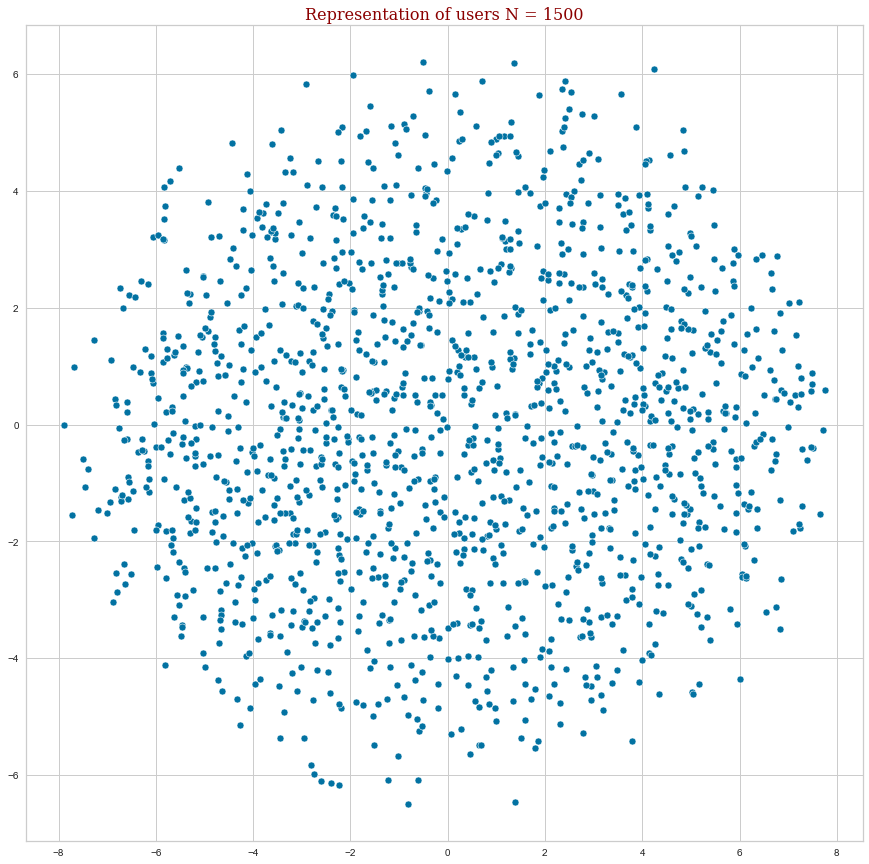

In [301]:
import seaborn as sns 
plt.rcParams['figure.figsize'] = (15, 15)  # (width, height)

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
sns.scatterplot(z[:,0], z[:,1])
plt.title('Representation of users N = 1500', loc='center',fontdict=font)
plt.show()
#plt.savefig('users.png')

Iteration: 0 - Best Inertia: nan
Iteration: 1 - Best Inertia: nan
Iteration: 2 - Best Inertia: nan
Iteration: 3 - Best Inertia: nan
Iteration: 4 - Best Inertia: nan
Iteration: 5 - Best Inertia: nan
Iteration: 6 - Best Inertia: nan
Iteration: 7 - Best Inertia: nan
Iteration: 8 - Best Inertia: nan
Iteration: 9 - Best Inertia: nan
Iteration: 10 - Best Inertia: nan
Iteration: 11 - Best Inertia: nan
Iteration: 12 - Best Inertia: nan
Iteration: 13 - Best Inertia: nan
Iteration: 14 - Best Inertia: nan
Iteration: 15 - Best Inertia: nan
Iteration: 16 - Best Inertia: nan
Iteration: 17 - Best Inertia: nan
Iteration: 18 - Best Inertia: nan
Iteration: 19 - Best Inertia: nan
Iteration: 20 - Best Inertia: nan
Iteration: 21 - Best Inertia: nan
Iteration: 22 - Best Inertia: nan
Iteration: 23 - Best Inertia: nan
Iteration: 24 - Best Inertia: nan
Iteration: 25 - Best Inertia: nan
Iteration: 26 - Best Inertia: nan
Iteration: 27 - Best Inertia: nan
Iteration: 28 - Best Inertia: nan
Iteration: 29 - Best Ine

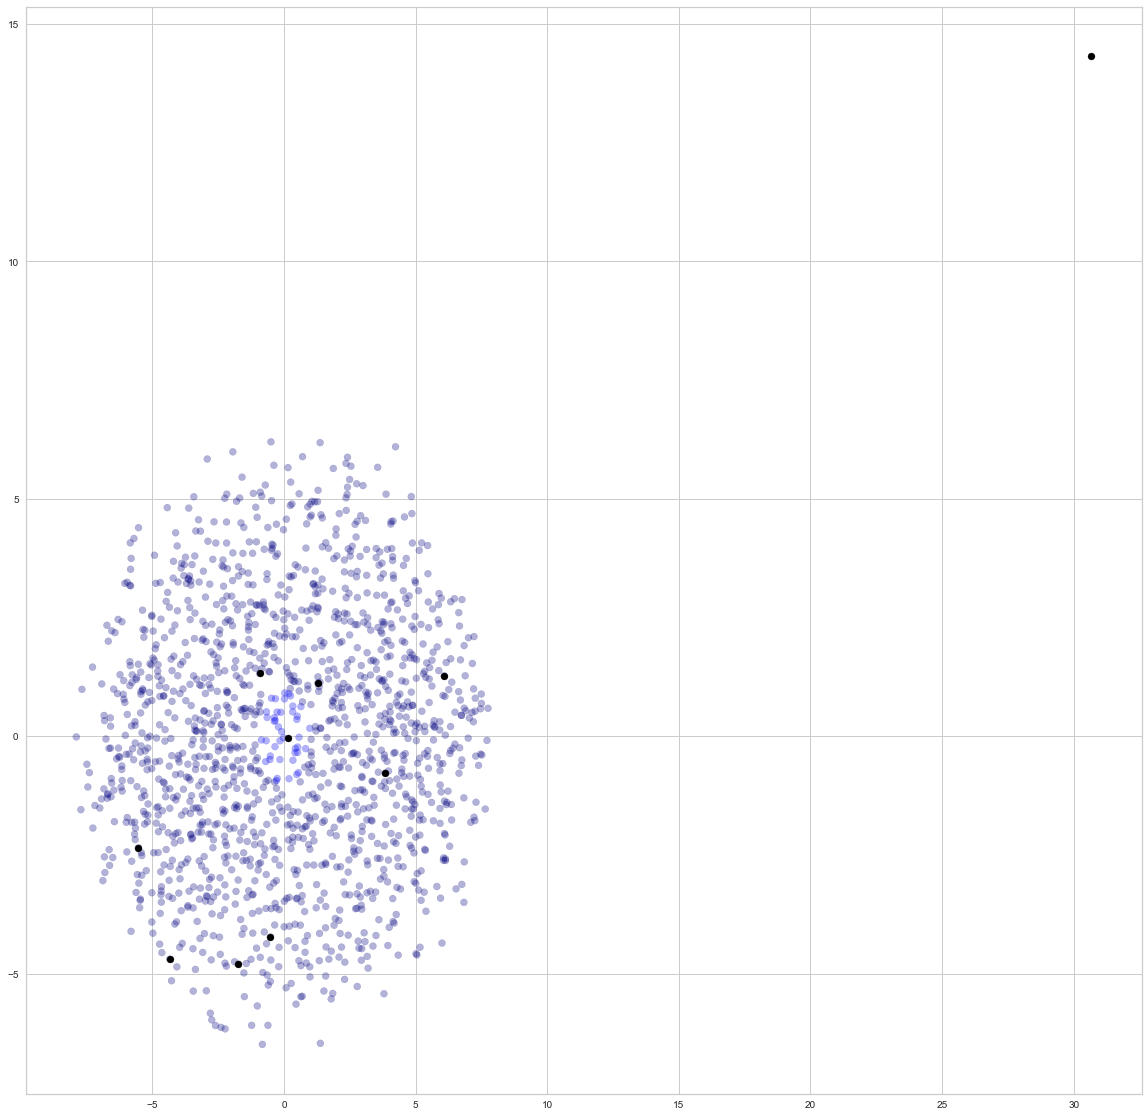

In [308]:
from KMeans_Poincare_2d import PoincareKMeans
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
colormap = get_cmap('jet')

#labels = res.keys()

model_kmeans_2d = PoincareKMeans(n_clusters=10,n_init=50,max_iter=200,tol=1e-10,verbose=True)
model_kmeans_2d.fit_predict(z)
clust_labels_2d = model_kmeans_2d.labels_
centroids_2d = model_kmeans_2d.cluster_centers_

colors = [colormap(x/model_kmeans_2d.n_clusters) for x in clust_labels_2d]

plt.figure(figsize=(20,20))
plt.scatter(z[:,0],z[:,1],alpha=0.3,c=colors)


for i in range(model_kmeans_2d.n_clusters):
    plt.scatter(centroids_2d[i,0],centroids_2d[i,1],alpha=1.0,c="black")
plt.show()

In [314]:
model_kmeans_2d = PoincareKMeans(n_clusters=10,n_init=50,max_iter=200,tol=1e-10,verbose=True)
model_kmeans_2d.fit_predict(vector_users)
clust_labels_2d = model_kmeans_2d.labels_
centroids_2d = model_kmeans_2d.cluster_centers_

colors = [colormap(x/model_kmeans_2d.n_clusters) for x in clust_labels_2d]

plt.figure(figsize=(20,20))
plt.scatter(z[:,0],z[:,1],alpha=0.3,c=colors)


for i in range(model_kmeans_2d.n_clusters):
    plt.scatter(centroids_2d[i,0],centroids_2d[i,1],alpha=1.0,c="black")
plt.show()

ValueError: operands could not be broadcast together with shapes (10,200) (10,2) 

In [309]:
# Trying in 3D

vectors_users_3d = []

for i in range(1,1501):
    
    print(f"user {i}")
    
    all_cats = users_profile_data("Users_Cats.csv", i)
    
    vectors_3d = []
    
    for x in all_cats:
        vect_ = model.get_vector(x)
        vect_ = vect_.reshape(1,200)
        vectors_3d.append(vect)
          
    # concatenating all vector coordinates         
    v_3d = np.concatenate(vectors_3d)
    #print(v.shape)
    
    # average for each user 
    mean_vectors_3d = np.mean(v_3d, axis=0,keepdims=True)
    #mean_vectors = mean_vectors.reshape(1,-1)
    #print(mean_vectors_.shape)
    
    # append mean from all users
    vectors_users_3d.append(mean_vectors_3d)


vector_users_3d = np.array(vectors_users_3d)
vector_users_3d = vector_users_3d.reshape(-1,200)
print(vector_users_3d.shape)

# reduncing the 200D into 2D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, random_state=123, perplexity=100, n_iter=5000)
z_3d = tsne.fit_transform(vector_users)



user 1
user 2
user 3
user 4
user 5
user 6
user 7
user 8
user 9
user 10
user 11
user 12
user 13
user 14
user 15
user 16
user 17
user 18
user 19
user 20
user 21
user 22
user 23
user 24
user 25
user 26
user 27
user 28
user 29
user 30
user 31
user 32
user 33
user 34
user 35
user 36
user 37
user 38
user 39
user 40
user 41
user 42
user 43
user 44
user 45
user 46
user 47
user 48
user 49
user 50
user 51
user 52
user 53
user 54
user 55
user 56
user 57
user 58
user 59
user 60
user 61
user 62
user 63
user 64
user 65
user 66
user 67
user 68
user 69
user 70
user 71
user 72
user 73
user 74
user 75
user 76
user 77
user 78
user 79
user 80
user 81
user 82
user 83
user 84
user 85
user 86
user 87
user 88
user 89
user 90
user 91
user 92
user 93
user 94
user 95
user 96
user 97
user 98
user 99
user 100
user 101
user 102
user 103
user 104
user 105
user 106
user 107
user 108
user 109
user 110
user 111
user 112
user 113
user 114
user 115
user 116
user 117
user 118
user 119
user 120
user 121
user 122
user 123
u

In [310]:
z_3d

array([[ 214.54578 ,   53.71823 , -154.64888 ],
       [ -50.05901 ,  223.97067 ,   23.610538],
       [ 100.03711 ,  -89.09235 ,  -34.47584 ],
       ...,
       [-138.64914 ,   47.835632,  -58.74778 ],
       [  33.18358 ,  280.06738 ,  129.64386 ],
       [ 104.7085  ,  -61.136784,  181.46916 ]], dtype=float32)

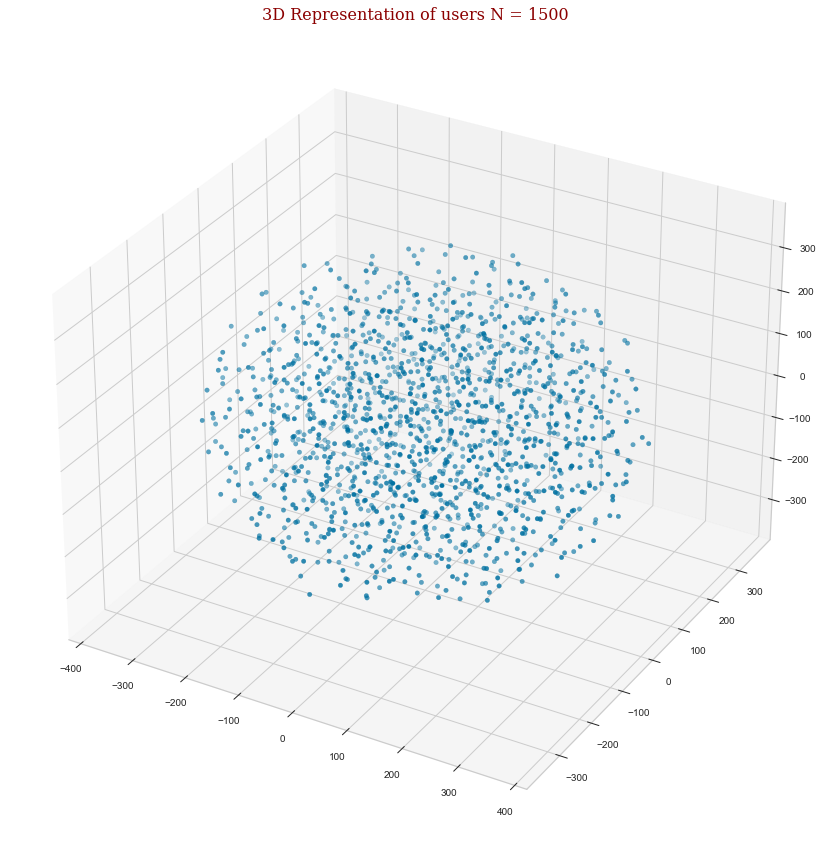

In [311]:
#plt.rcParams['figure.figsize'] = (15, 15)  # (width, height)
fig = plt.figure()
ax = plt.axes(projection='3d')

plt.title('3D Representation of users N = 1500', loc='center',fontdict=font)
ax.scatter3D(z_3d[:,0], z_3d[:,1], z_3d[:,2],cmap='Greens');